In [1]:
from poloniex import Poloniex
from time import time
import json

polo = Poloniex()
start=time() - polo.YEAR

if False:
  data = polo.returnChartData('USDT_BTC', period=86400, start=start)
  with open('data.json', 'w') as outfile:
    json.dump(data, outfile)

with open('data.json') as infile:
  market = json.load(infile)

market[0]

{'close': 895,
 'date': 1484870400,
 'high': '902.42999999',
 'low': '882.5432',
 'open': '900.30000001',
 'quoteVolume': '940.82405676',
 'volume': '841765.1320593',
 'weightedAverage': '894.71046792'}

In [2]:
import pandas as pd
df = pd.io.json.json_normalize(market)
df.sample()

,close,date,high,low,open,quoteVolume,volume,weightedAverage
86,1212.5,1492300800,1217.00000001,1190.00000009,1193.94839339,2691.61774504,3253026.4592128,1208.57668783


In [3]:
df[list(df)] = df[list(df)].apply(pd.to_numeric)
df['date'] = df['date'].apply(pd.to_datetime, unit='s')

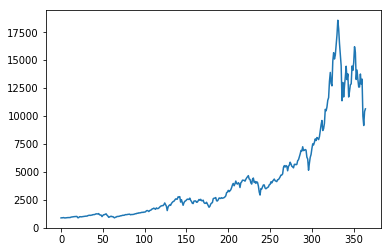

In [4]:
import matplotlib
%matplotlib inline
df.describe()
df['low'].plot()

In [5]:
df['up'] = 0
df['high_rate'] = 0
df['low_rate'] = 0
df['close_rate'] = 0

df.head()

,close,date,high,low,open,quoteVolume,volume,weightedAverage,up,high_rate,low_rate,close_rate
0,895.00000,2017-01-20,902.430000,882.54320,900.300000,940.824057,8.417651e+05,894.710468,0,0,0,0
1,925.70600,2017-01-21,928.518494,894.00000,895.099711,1522.358253,1.397884e+06,918.235895,0,0,0,0
2,924.11940,2017-01-22,939.060710,894.10010,925.706000,1706.434429,1.567170e+06,918.388676,0,0,0,0
3,912.22165,2017-01-23,927.235100,912.22165,923.990000,1550.690618,1.425305e+06,919.142208,0,0,0,0
4,885.00000,2017-01-24,923.000000,884.28100,912.221650,2382.927366,2.149635e+06,902.098438,0,0,0,0


In [6]:
prev_up = 0
for index, row in df.iterrows():
    try:
        df.at[index, 'prev_up'] = prev_up
        df.at[index, 'close_rate'] = row['close']-df.loc[index-1]['close']
        df.at[index, 'high_rate'] = row['high']-df.loc[index-1]['high']
        df.at[index, 'low_rate'] = row['low']-df.loc[index-1]['low']
        if (df.loc[index+1]['close']>row['close']):
            df.at[index, 'up'] = 1
            prev_up = 1
        else:
            df.at[index, 'up'] = 0
            prev_up = 0
    except KeyError as e:
        pass
df.head(10)

,close,date,high,low,open,quoteVolume,volume,weightedAverage,up,high_rate,low_rate,close_rate,prev_up
0,895.000000,2017-01-20,902.430000,882.543200,900.300000,940.824057,8.417651e+05,894.710468,0,0,0,0,0.0
1,925.706000,2017-01-21,928.518494,894.000000,895.099711,1522.358253,1.397884e+06,918.235895,0,26,11,30,0.0
2,924.119400,2017-01-22,939.060710,894.100100,925.706000,1706.434429,1.567170e+06,918.388676,0,10,0,-1,0.0
3,912.221650,2017-01-23,927.235100,912.221650,923.990000,1550.690618,1.425305e+06,919.142208,0,-11,18,-11,0.0
4,885.000000,2017-01-24,923.000000,884.281000,912.221650,2382.927366,2.149635e+06,902.098438,1,-4,-27,-27,0.0
5,892.667773,2017-01-25,899.990000,882.080000,885.100000,1064.256635,9.488559e+05,891.566831,1,-23,-2,7,1.0
6,914.097671,2017-01-26,918.000000,892.667773,892.667773,1099.568637,9.975648e+05,907.232818,1,18,10,21,1.0
7,917.027451,2017-01-27,921.650000,907.800000,916.000000,852.670935,7.812089e+05,916.190376,1,3,15,2,1.0
8,918.586004,2017-01-28,926.000000,909.987300,917.436775,900.645563,8.283338e+05,919.711219,0,4,2,1,1.0
9,914.999800,2017-01-29,923.000000,911.860406,918.990000,406.000777,3.725643e+05,917.644336,1,-3,1,-3,0.0


In [7]:
from sklearn.cross_validation import train_test_split

#X = df[['close', 'high', 'low', 'prev_up']]
X = df[['prev_up','close_rate','high_rate','low_rate']]
y = df['up']

X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.2, 
                                                    random_state=0)

/Users/hild/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [8]:
df.corr()

,close,high,low,open,quoteVolume,volume,weightedAverage,up,high_rate,low_rate,close_rate,prev_up
close,1.000000,0.998374,0.997848,0.995246,-0.032855,0.762353,0.999163,-0.095933,0.088154,0.067477,0.073194,-0.042211
high,0.998374,1.000000,0.996194,0.997824,-0.015969,0.783253,0.998947,-0.097323,0.065011,0.031921,0.029995,-0.065496
low,0.997848,0.996194,1.000000,0.995683,-0.050931,0.741268,0.999003,-0.097113,0.069447,0.077024,0.046886,-0.052739
open,0.995246,0.997824,0.995683,1.000000,-0.023455,0.775373,0.997226,-0.095656,0.017741,0.000773,-0.024245,-0.088127
quoteVolume,-0.032855,-0.015969,-0.050931,-0.023455,1.000000,0.461377,-0.033002,-0.017155,-0.046691,-0.204879,-0.097004,-0.187497
volume,0.762353,0.783253,0.741268,0.775373,0.461377,1.000000,0.762836,-0.070965,-0.016730,-0.238179,-0.117113,-0.178210
weightedAverage,0.999163,0.998947,0.999003,0.997226,-0.033002,0.762836,1.000000,-0.096908,0.071132,0.058674,0.044412,-0.056536
up,-0.095933,-0.097323,-0.097113,-0.095656,-0.017155,-0.070965,-0.096908,1.000000,0.004585,-0.027919,-0.003410,0.049302
high_rate,0.088154,0.065011,0.069447,0.017741,-0.046691,-0.016730,0.071132,0.004585,1.000000,0.548163,0.727657,0.295809
low_rate,0.067477,0.031921,0.077024,0.000773,-0.204879,-0.238179,0.058674,-0.027919,0.548163,1.000000,0.687635,0.317147


In [9]:
from sklearn.linear_model import LogisticRegression

model = LogisticRegression()
model = model.fit(X_train, y_train)


In [10]:
model

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

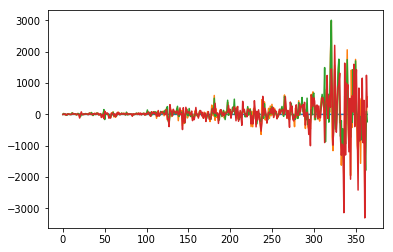

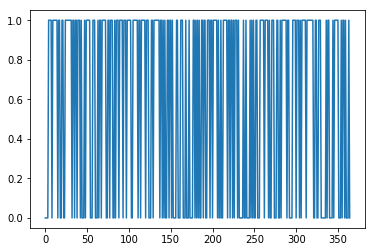

In [11]:
from matplotlib import pyplot as plt


plt.figure(0)
plt.plot(X)
plt.figure(1)
plt.plot(y)

In [12]:
from sklearn.model_selection import cross_val_score
cross_val_score(model, X, y, scoring='accuracy') 

array([ 0.59016393,  0.59016393,  0.52066116])

In [13]:
model.get_params()

{'C': 1.0,
 'class_weight': None,
 'dual': False,
 'fit_intercept': True,
 'intercept_scaling': 1,
 'max_iter': 100,
 'multi_class': 'ovr',
 'n_jobs': 1,
 'penalty': 'l2',
 'random_state': None,
 'solver': 'liblinear',
 'tol': 0.0001,
 'verbose': 0,
 'warm_start': False}

In [14]:
from sklearn.neural_network import MLPClassifier
clf = MLPClassifier(solver='lbfgs', alpha=1e-5,
                    hidden_layer_sizes=(5, 2), random_state=1)
clf.fit(X_train, y_train)

MLPClassifier(activation='relu', alpha=1e-05, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(5, 2), learning_rate='constant',
       learning_rate_init=0.001, max_iter=200, momentum=0.9,
       nesterovs_momentum=True, power_t=0.5, random_state=1, shuffle=True,
       solver='lbfgs', tol=0.0001, validation_fraction=0.1, verbose=False,
       warm_start=False)

In [15]:
#print(clf.predict_proba([[924, 939, 894]])) 
#print(model.predict_proba([[924, 939, 894]]))
for index in range(5):
    #print(df.loc[index+1,['close','high','low', 'prev_up']].values)
    #print(df.loc[index+1,['prev_up']].values)
    #print(clf.predict_proba([df.loc[index+1,['close','high','low', 'prev_up']].values]), df.loc[index+1,['up']])    
    print(clf.predict_proba([df.loc[index+1,['prev_up','close_rate','high_rate', 'low_rate']].values]), df.loc[index+1,['up']])    

[[ 0.4111219  0.5888781]] up    0
Name: 1, dtype: object
[[ 0.4111219  0.5888781]] up    0
Name: 2, dtype: object
[[ 0.4111219  0.5888781]] up    0
Name: 3, dtype: object
[[ 0.4111219  0.5888781]] up    1
Name: 4, dtype: object
[[ 0.4111219  0.5888781]] up    1
Name: 5, dtype: object


In [ ]:
from sklearn.linear_model import LinearRegression

from sklearn.preprocessing import PolynomialFeatures
poly = PolynomialFeatures(degree=7)
X_ = poly.fit_transform(X)

X_train_, X_test_, y_train_, y_test_ = train_test_split(X_, y, 
                                                    test_size=0.2, 
                                                    random_state=0)

model2 = LinearRegression()
model2 = model.fit(X_train, y_train)
predict = [[924, 939, 894]]
predict_ = poly.fit_transform(predict)

model2.predict(predict_)


In [ ]:
scores = cross_val_score(model2, X_train, y_train, scoring='accuracy') 
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

In [ ]:
from sklearn.metrics import accuracy_score
accuracy_score(y_test, model2.predict(X_test))